# Generating AI drawings using DCGAN and the Google Quick, Draw! dataset

## Introduction

---



### The project
In this notebook we will apply a Deep Convolutional Generative Adversarial Network (DCGAN) to the Google Quick,Draw! dataset, to create a generator model able to convincingly draw several objects.

### The sources
#### Google Quick, Draw! database
This is a collection of more than 50 million grayscale doodles, made by users worldwide. For a good understanding of how it works, you can still participate on the [Quick, Draw! website](https://quickdraw.withgoogle.com).
Users are given a category at random (out of 345 types of objects), and they have up to 20 seconds to draw it, or until the Google algorithm guesses the category.

![Drawings sample](ressources/sample_quick_draw.PNG)
*A selection of bears*

As we can see, some drawings are cut short due to the algorithm guessing the category before the user had finished. This will cause problems when generating some types of images (rabbits missing eyes, notably).

#### Tensorflow 2.0 DCGAN tutorial
This tutorial is a very thorough step-by-step guide on generating new images using a [DCGAN](https://arxiv.org/pdf/1511.06434.pdf). Most of the work I had to do was to plug the Quick, Draw! dataset and train the models. You can find the tutorial [here](https://www.tensorflow.org/alpha/tutorials/generative/dcgan).

#### Inspired by "Dreaming of Electric Sheep"
Computer science doctorate Dr.Ernesto Diaz-Aviles has created and published a book containing 10 000 AI drawings of sheep, using the same methods. For more information, read their [article on Medium](https://medium.com/libreai/dreaming-of-electric-sheep-d1aca32545dc).

## The code

---



### Downloading images and setting up prerequisites

This notebook requires Tensorflow 2.0. Install it using your preferred method, be sure to specify a version. Here we are training our model on the GPU, but you can also use a CPU/TPU.

In [0]:
# !pip install --force-reinstall -q tensorflow-gpu==2.0.0-alpha0

In [2]:
# Verifying if the Tensorflow version is 2.0
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [0]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Loads the list of categories from the official Quick, Draw! Github. We are choosing the rabbit for this example.

In [4]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'rabbit'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [5]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

train_images = np.load(f'npy_files/{category}.npy')
print(f'{len(train_images)} images to train on')

# You can limit the amount of images you use for training by setting :
# train_images = train_images[:10000]

155288 images to train on


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# BATCH size will determine how many predictions the model will generate and evaluate. A low value tends to overfit, a high value to lack precision
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


### Defining the generator/discriminator models and their parameters

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



In [0]:
# Generates the first image to be evaluated by the discriminator model : random normal noise
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

# Evaluates our noise. Returns negative values for "bad" drawings, and positive valyes for "good" ones
print(decision)

tf.Tensor([[-0.00130993]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [0]:
# Creates a folder for our models
if not os.path.isdir('training_checkpoints'):
    os.mkdir('training_checkpoints')
if not os.path.isdir(f'training_checkpoints/{category}'):
    os.mkdir(f'training_checkpoints/{category}')
    
checkpoint_dir = f'training_checkpoints/{category}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Choose the number of epochs according to your computing power
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime so it's easier to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images of our predictions as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
if not os.path.isdir('images'):
    os.mkdir('images')
if not os.path.isdir(f'images/{category}'):
    os.mkdir(f'images/{category}')

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')


    plt.savefig(f'images/{category}/image_at_epoch_{100+epoch:05d}.png')
    plt.show()

### Training our model

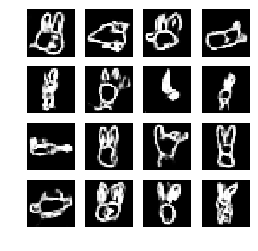

CPU times: user 15min 24s, sys: 3min 52s, total: 19min 17s
Wall time: 50min 43s


In [21]:
%%time
train(train_dataset, EPOCHS)

## Displaying our generated images

---



In [0]:
def generate_images(model, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(predictions[i, :, :, 0] * -127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()


Sample of 64 generated rabbit images

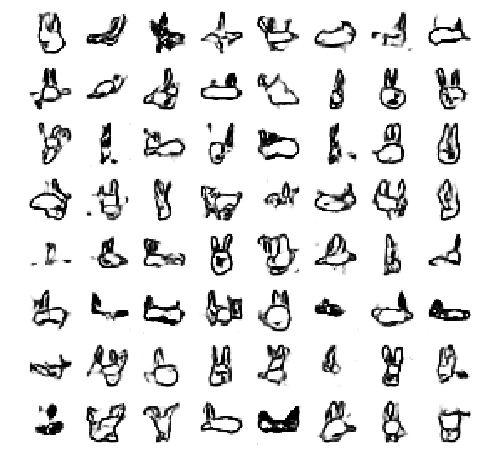

In [23]:
generate_images(generator, tf.random.normal([64, 100]))                                                                                                                                        

Sample of 64 original drawings

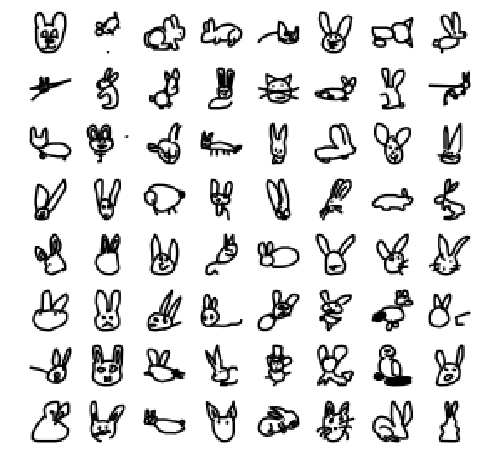

In [61]:
fig = plt.figure(figsize=(8,8))

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(train_images[10000+i, :, :, 0] * -127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

## Conclusion


---


We can see that after 100 epochs (50 minutes of training on a GPU accelerated Google Colab notebook), the results are starting to be recognisable as being rabbits. However, we still havent reached the quality of the original drawings.

A few possible reasons : 
- Original drawings are very diverse : sometimes the image will contain a full rabbit, sometimes just the head. The generator model seems to consistently draw their common part, the rabbit ears. However, it will also be confused as to whether it should be drawing a head (round shape) or a body (elongated shape)
- Original drawings are sometimes incomplete : addind to the confusion between body and head, many of the original drawings seem to be missing facial features (eyes, nose, mouth), so our model has difficulties reproducing them

It is probably possible to increase the quality of our generated images by adding a few steps of pre-processing, or tweaking our neural network parameters.

It can also be interesting to train our model on different categories to see if the DCGAN is better at more straightforward drawings. Note that I have tested it on the bear category, giving similar results (missing facial features), and wine bottles which were better but much less challenging.